# Time Series Classification Algorithms - (4) Shapelet Based

<div style="border: 1px solid #007acc; background-color: #e6f4ff; padding: 10px; border-radius: 5px; color: black;">
  <strong>📘 Info:</strong> I do not claim ownership of the content in this notebook. It is based on official <a href="https://www.aeon-toolkit.org/en/latest/examples.html" target="_blank">aeon tutorials</a>, and parts of the code or text may have been copy-pasted or adapted directly from those or other sources for learning purposes.
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

import time

In [3]:
from aeon.datasets import load_classification
from aeon.utils.discovery import all_estimators
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform
from aeon.visualisation import (
    ShapeletClassifierVisualizer, ShapeletTransformerVisualizer,
    ShapeletVisualizer
)

# all_estimators("classifier", tag_filter={"algorithm_type": "shapelet"})

In [4]:
from aeon.classification.shapelet_based import LearningShapeletClassifier, ShapeletTransformClassifier

In [5]:
DATASET_NAMES = [
    "MelbournePedestrian",
    "ArrowHead",
    "Colposcopy"
]

X_train_dict, y_train_dict = {}, {}
X_test_dict, y_test_dict = {}, {}

accuracy_dict, f1_score_dict, duration_dict = {}, {}, {}

for dataset_name in DATASET_NAMES: 
    X_train_dict[dataset_name], y_train_dict[dataset_name] = load_classification(
        dataset_name, split="train"
    )
    X_test_dict[dataset_name], y_test_dict[dataset_name] = load_classification(
        dataset_name, split="test"
    )

    X_train_dict[dataset_name] = X_train_dict[dataset_name].squeeze(1)
    X_test_dict[dataset_name] = X_test_dict[dataset_name].squeeze(1)

    accuracy_dict[dataset_name] = {}
    f1_score_dict[dataset_name] = {}
    duration_dict[dataset_name] = {}

```bibtex
@inbook{faouzi2024,
  author = {Johann Faouzi},
  title = {Time Series Classification: A Review of Algorithms and Implementations},
  year = {2024},
  month = {March},
  booktitle = {Advances in Time Series Analysis and Forecasting},
  publisher = {IntechOpen},
  isbn = {978-0-85466-053-7},
  doi = {10.5772/intechopen.1004810},
}
```

"A shapelet is defined as a subsequence of consecutive observations from a time series. In some use cases, specific shapelets can be characteristic of the classes and thus helpful at discriminating them. Several algorithms rely on shapelets, either by extracting the best shapelets from the training data set or by directly learning them." \cite{faouzi2024}

A Shapelet $S$ is defined as a time series (size $m$) subseries of a series in the training data that is useful in discriminating between classes. A shapelet $S$ has a length $l$, where $l < m$.

https://www.aeon-toolkit.org/en/latest/examples/classification/shapelet_based.html

In [6]:
shapelet_length = 10
shapelet_example = X_train_dict[DATASET_NAMES[0]][0, 7 : 7 + shapelet_length]
shapelet_example

array([ 422.,  875., 1003., 1351., 1613., 2937., 2954., 2167., 2330.,
       2191.])

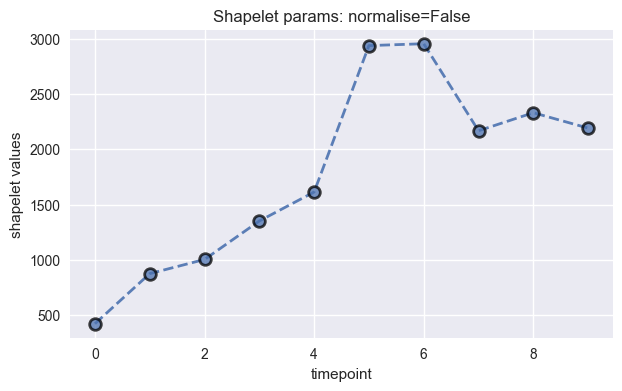

In [7]:
shapelet_vis = ShapeletVisualizer(shapelet_example)
fig = shapelet_vis.plot(figure_options={"figsize": (7, 4)})

Historicaly, shapelets were first proposed as a primitive for time series machine learning and were used as spliting criterion in a decision tree for time series classification. To make this work, a distance dist between a shapelet $S$ and a time series $X$ was defined such as $\text{dist}(S, X) \rightarrow \mathbb{R}$.

The Shapelet-based splitting criterion was then based on a threshold $\lambda$ on the distance as $\text{dist}(S, X) < \lambda$, to direct a time series $X$ to the left or right child node, with each node being defined by another shapelet.

This way of calculating the distance, which is still used today, was to compute the Euclidean distance between $X$ and all subsequences of size $l$ in $X$, and to return the minimum. 

This represents the idea that the distance of a shapelet to a time series is the distance between the shapelet and the best matching subsequence of the same size in $X$. We can illustrate this formula with the following image, where we would extract the minimum from the values $v$:

<img src="images/04_shapelet.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

We can position the shapelet on its best-matching subsequence in a time series X:

https://www.aeon-toolkit.org/en/latest/examples/classification/shapelet_based.html

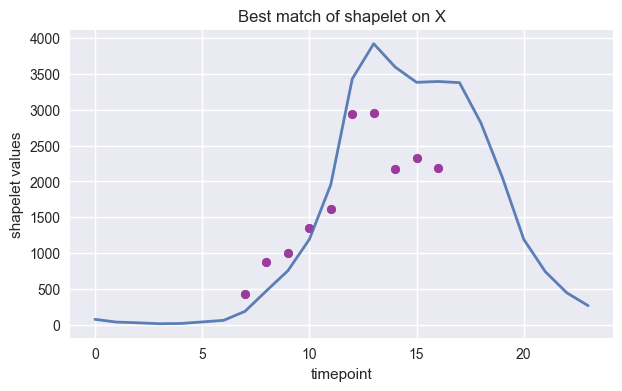

In [8]:
fig = shapelet_vis.plot_on_X(X_test_dict[DATASET_NAMES[0]], figure_options={"figsize": (7, 4)})

Or we can visualize the distance between the shapelet $S$ and all subsequences of the same size in $X$. We refer to this as the distance vector between $S$ and $X$, and its defined as:

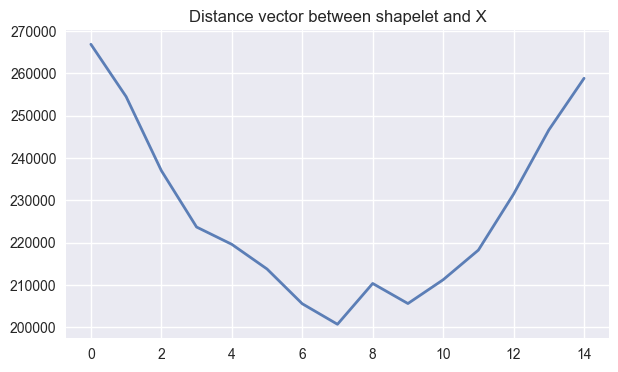

In [9]:
fig = shapelet_vis.plot_distance_vector(X_test_dict[DATASET_NAMES[0]], figure_options={"figsize": (7, 4)})

Now that we understand what shapelets are and how they are used, a question is left unanswered, how do we extract them? This process is hidden behind the fit method of the shapelet-based transformations. We can distinguish types of shapelet extraction processes:
- Exaustive search: In this case, we extract all possible shapelet candidates (i.e. all subsequences of a given length) and evalute their quality to select the best ones. For example, after removing self-similar shapelets, we can compute the information gain of a shapelet $S$ based on $\text{dist}(S, X) < \lambda$.
- Heuristic-based search: One issue of the exhaustive search is that it can take a long time to extract and evaluate all shapelet candidates in a dataset. A lot of different approaches are proposed in the literature try to approximate the result of the exaustive search while minimizing the time needed to obtain the shapelets.
  - For example, instead of evaluating all possible candidates, RandomShapeletTransform uses a parameter n_shapelet_samples to randomly extract a limited number of shapelets from the input. It then restricts the quality evaluation to these randomly extracted candidates to reduce the search time. It also considers the notion of self-similar shapelets during the candidate extraction to avoid sampling similar shapelets as they would be redundant.
  - Others such as SAST only select a small number of “reference” time series in the training data where all subsequences will be considered as shapelets without evaluating their quality. This leaves the “feature selection” step to the classifier that will use the transformation. RSAST uses the same approach but also uses some statistical critera to further reduce the number of candidates extracted from these reference time series.
  - Another approach used in RandomDilatedShapeletTransform is to use a semi-random extraction which is guided by a masking of the input space. Once a shapelet has been randomly sampled from a time series, the neighboring points around the sampling point are removed from the list of available sampling points. This avoids extracting self-similar shapelets and improves the diversity of the extracted shapelet set. The number of neighboring points affected by this process is controlled with the alpha_similarity parameter.
- Shapelet generation: This last approach takes another view at the problem: What if the best shapelets for my dataset are not present in the training data? The goal is to use optimization methods, such as gradient descent or evolutionary algorithm, to generate shapelet values instead of extracting them from the input. The first shapelet generation method was Learning Shapelet.

https://www.aeon-toolkit.org/en/latest/examples/classification/shapelet_based.html#How-are-shapelets-extracted-from-the-time-series-?

We can visualize the notion of self similarity using the following image. Consider that we sample the shapelet highlighted in green, under self similarity (which is a special case of alpha_similarity where alpha=1), all the neighboring subsequences, which are stacked and highlighted in red, cannot be considered as shapelet candidates since they would overlap. The next valid candidates would be the ones highlighted in orange since they don’t overlap with the green shapelet. The number of pruned candidates is determined by $\alpha \times l$ with $l$ the length of the sampled shapelet (in green).

<img src="images/04_shapelet2.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

https://www.aeon-toolkit.org/en/latest/examples/classification/shapelet_based.html#Shapelet-%22self-similarity%22

## 1. Shapelet Transform

```bibtex
@inproceedings{lines2012,
  author = {Jason Lines and Luke M. Davis and Jon Hills and Anthony Bagnall},
  title = {A Shapelet Transform for Time Series Classification},
  booktitle = {Proceedings of the 18th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD'12)},
  year = {2012},
  pages = {289--297},
  publisher = {ACM},
  doi = {10.1145/2339530.2339579},
  url = {https://doi.org/10.1145/2339530.2339579}
}
```

Proposed by \cite{lines2012}.

"Lines and colleagues proposed an algorithm, called Shapelet Transform, that extracts the best shapelets from a data set. Let $X$ be a time series of n real-valued observations and $S$ a shapelet of $l$ real numbers, with $l <= n$. The distance between the shapelet $S$ and the time series $X$, denoted $\text{d}(S, X)$, is defined as the minimum of the squared Euclidean distances between $S$ and all the shapelets of length $l$ from $X$:" \cite{faouzi2024}

<img src="images/04_stransformation.png" style="width:400px; border: 1px solid #ccc; border-radius: 5px;">

"The algorithm extracts all the shapelets whose length belongs to a range, the range being a hyperparameter of the algorithm, and selects the $k$ best shapelets, $k$ being another hyperparameter of the algorithm. This process can be seen as univariate feature extraction, where each feature is the distance between a given shapelet and all the time series in the data set. The shapelets are ranked based on the F-statistics of the analysis of variance test that compares the between- and within- class variabilities. In order to extract features (i.e., shapelets) that are not highly correlated, self-similar shapelets are removed, with any pair of shapelets being considered self-similar if they are from the same time series and have any overlapping indices." \cite{faouzi2024}

"Moreover, the definition of self-similarity for shapelets does not take into account the values of the shapelets, meaning that two shapelets very similar in terms of Euclidean distance but extracted from two different time series are not considered self-similar, even though they yield very similar features." \cite{faouzi2024}

The overall shapelet classification framework can be seen in the image below:

<img src="images/04_stransformation2.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

https://www.aeon-toolkit.org/en/latest/examples/classification/shapelet_based.html#Shapelet-Transform-for-Classification

Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

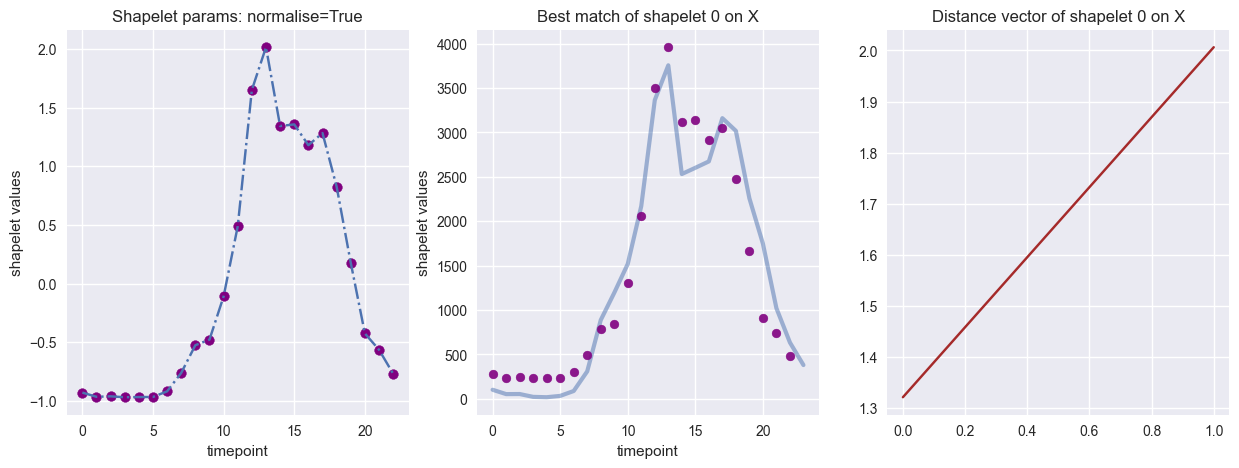

In [10]:
st_ = RandomShapeletTransform(
    max_shapelets=10,
    n_shapelet_samples=500,
)
st_.fit(X_train_dict[DATASET_NAMES[0]], y_train_dict[DATASET_NAMES[0]])
st_.transform(X_test_dict[DATASET_NAMES[0]]).shape

st_vis_ = ShapeletTransformerVisualizer(st_)
id_shapelet = 0

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
st_vis_.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
st_vis_.plot_on_X(
    id_shapelet,
    X_test_dict[DATASET_NAMES[0]][1],
    ax=ax[1],
    line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
st_vis_.plot_distance_vector(
    id_shapelet,
    X_test_dict[DATASET_NAMES[0]][1],
    ax=ax[2],
    line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

In [11]:
BATCH_SIZE = 32

In [12]:
method = "Shapelet Transfom"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    st = ShapeletTransformClassifier(
        estimator=RandomForestClassifier(ccp_alpha=0.01),
        n_shapelet_samples=80,
        max_shapelets=30,
        batch_size=BATCH_SIZE,
    )
    st.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    st_preds = st.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], st_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], st_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

Shapelet Transfom
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.42
F1-Score: 0.38
Duration: 1.71 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.73
F1-Score: 0.73
Duration: 0.12 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.35
F1-Score: 0.30
Duration: 0.18 seconds


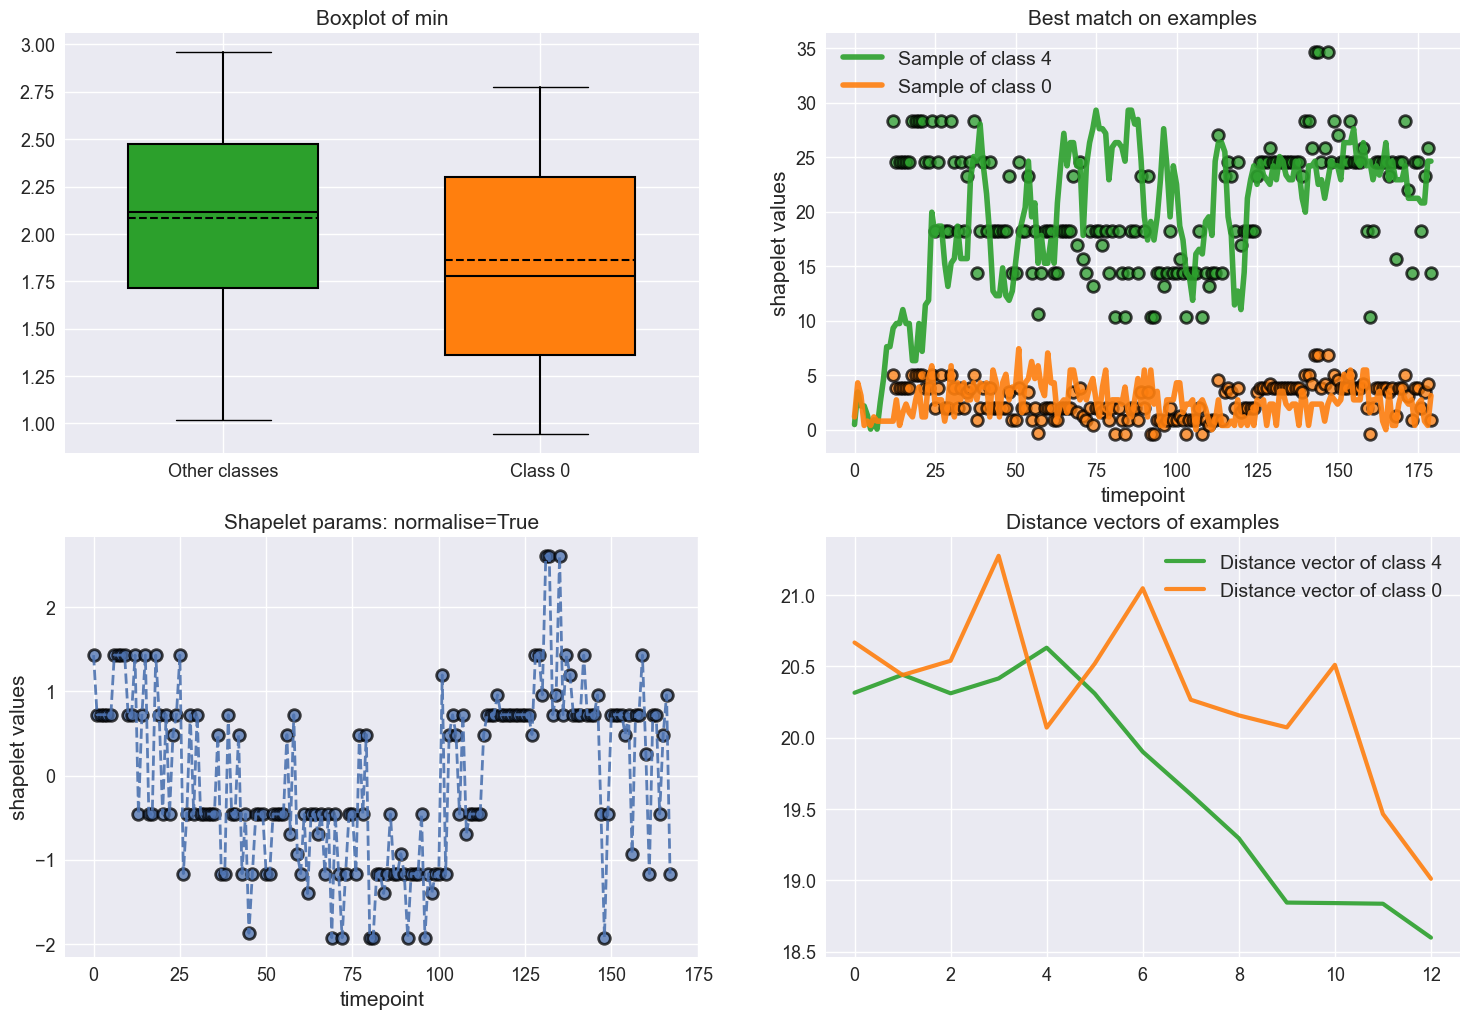

In [ ]:
st_vis = ShapeletClassifierVisualizer(st)
id_class = 0
fig = st_vis.visualize_shapelets_one_class(
    X_test_dict[dataset_name],
    y_test_dict[dataset_name],
    id_class,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

The four graphs each aid in the interpretability of shapelet-based algorithms. Here we take the most discriminating shapelet of class 0 and explore it for both local and global patterns.
- Boxplot of Min (Top Left): This graph introduces a new perspective by focusing on a global quality of the shapelet. It shows the distribution of the minimum distances between the shapelet and each time series across different classes. As expected, the shapelet fits class 0 more closely than the other classes.
- Best Match on Examples (Top Right): This graph extends the best match visualization by showing how the shapelet fits a random time series from each class. The green and orange curves represent samples from classes 1 and 0, respectively. The shapelet should, and does, align more closely with the orange time series of class 0, illustrating its effectiveness in distinguishing between the two classes according to a local pattern.
- Shapelet Params (Bottom Left): This graph, already introduced, elegantly displays the shapelet’s pattern over time.
- Distance Vectors of Examples (Bottom Right): This graph is an extension of the distance vector visualization, offering a comparison of how well the shapelet fits the two time series, from the ‘Best Match on Examples’ graph, at each point. This allows for a global understanding of how well the shapelet fits a time series at any point.

https://www.aeon-toolkit.org/en/latest/examples/classification/shapelet_based.html#Shapelet-Transform-for-Classification

## 2. Learning Shapeletes

```bibtex
@inproceedings{grabocka2014,
  author = {Josif Grabocka and Nicolas Schilling and Martin Wistuba and Lars Schmidt-Thieme},
  title = {Learning Time-Series Shapelets},
  booktitle = {Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '14)},
  year = {2014},
  pages = {392--401},
  address = {New York, NY, USA},
  publisher = {ACM Press},
  url = {http://dl.acm.org/citation.cfm?doid=2623330.2623613},
  doi = {10.1145/2623330.2623613}
}
```

Proposed by \cite{grabocka2014}.

"In order to address the limitations of the Shapelet Transform algorithm, another algorithm relying on learning shapelets, instead of extracting them, was proposed.""

"The distance between a shapelet and a time series defined in Shapelet Transform relies on the minimum function, which is not differentiable. Similar to the soft-DTW variant of DTW, the minimum function is replaced with a smooth minimum function, namely the LogSumExp function, which is differentiable. The logistic regression algorithm is used as the machine learning classifier built on top of the transformation."

"Since both the transformation and classification functions are differentiable, the chain rule allows for computing the gradients of the objection function with respect to the shapelets and the logistic regression coefficients, respectively, thus minimizing the objective function can be attempted to be solved by gradient descent."

"Learning shapelets instead of extracting them has several advantages. First, it may lead to shapelets that are not from the data set but are discriminative of the classes. Second, it does not require going through the whole data set, and thus may be faster to train, especially with stochastic variants of gradient descent."

"Nonetheless, learning shapelets also comes with drawbacks. As both the shapelets and the logistic regression coefficients need to be learned, the objective function is not convex (one can see the analogy with some clustering algorithms, such as k-means and Gaussian mixture models, where both the parameters and the members of the clusters need to be learned). Therefore, the optimization algorithm may converge to a bad local minimum. It also leads to more hyperparameters as the optimization process is a key component of the algorithm. Finally, as learning shapelets is embedded into the algorithm, it may not be optimal to try other classifiers than logistic regression later on, whereas the Shapelet Transform algorithm is independent of the machine learning classifier, and thus, the transformation step can be computed only once and many classifiers can be built on top of it to find the best performing classifier." \cite{faouzi2024}

<img src="images/04_learningshapelets.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

https://tslearn.readthedocs.io/en/latest/user_guide/shapelets.html#learning-time-series-shapelets

In [14]:
method = "Learning Shapelets"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    ls = LearningShapeletClassifier(batch_size=BATCH_SIZE)
    ls.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    ls_preds = ls.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], ls_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], ls_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

Learning Shapelets


/Users/zamith/Doutorado/TSC_XAI_Notebooks/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.10
F1-Score: 0.02
Duration: 343.95 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.70
F1-Score: 0.71
Duration: 206.68 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.24
F1-Score: 0.23
Duration: 216.31 seconds


## 3. Comparison between the Classifiers

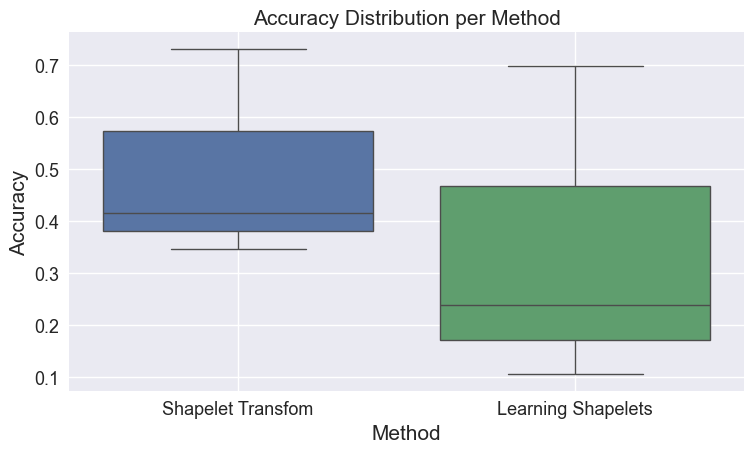

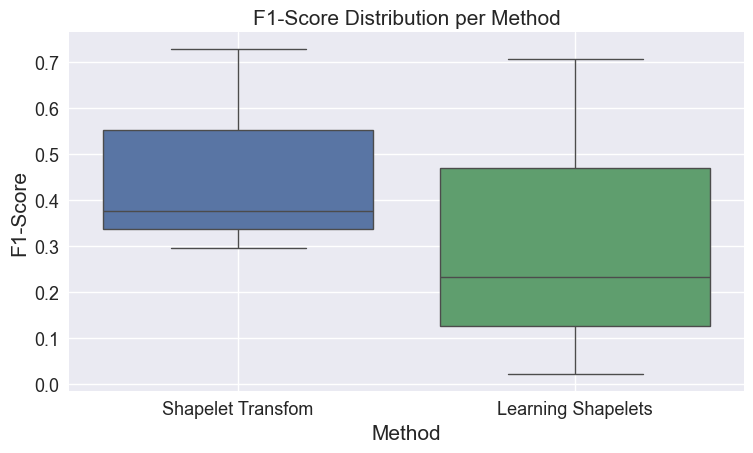

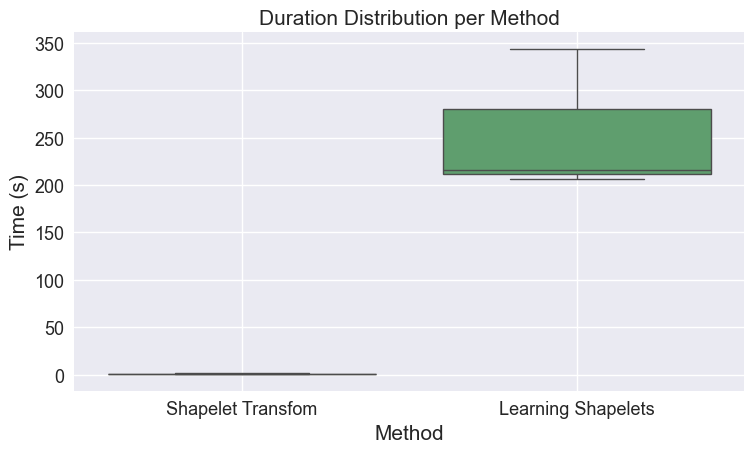

In [15]:
datasets = list(accuracy_dict.keys())
methods = list(next(iter(accuracy_dict.values())).keys())

def prepare_long_format(metric_dict, metric_name):
    records = []
    for ds in datasets:
        for method in methods:
            val = metric_dict[ds][method]
            if isinstance(val, (int, float)):
                records.append({
                    "Dataset": ds,
                    "Method": method,
                    "Metric": float(val),
                    "Type": metric_name
                })
    return pd.DataFrame(records)

df_accuracy = prepare_long_format(accuracy_dict, "Accuracy")
df_f1 = prepare_long_format(f1_score_dict, "F1-Score")
df_duration = prepare_long_format(duration_dict, "Duration (s)")

df_all = pd.concat([df_accuracy, df_f1, df_duration], ignore_index=True)

def plot_boxplot(df, title, ylabel):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="Method", y="Metric", hue="Method")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Method")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_boxplot(df_accuracy, "Accuracy Distribution per Method", "Accuracy")
plot_boxplot(df_f1, "F1-Score Distribution per Method", "F1-Score")
plot_boxplot(df_duration, "Duration Distribution per Method", "Time (s)")